# Melanoma Classification

Skin cancer is the most prevalent type of cancer. Melanoma, specifically, is responsible for 75% of skin cancer deaths, despite being the least common skin cancer. The American Cancer Society estimates over 100,000 new melanoma cases will be diagnosed in 2020. It's also expected that almost 7,000 people will die from the disease. As with other cancers, early and accurate detection—potentially aided by data science—can make treatment more effective.

In this competition, you’ll identify melanoma in images of skin lesions. In particular, you’ll use images within the same patient and determine which are likely to represent a melanoma. Using patient-level contextual information may help the development of image analysis tools, which could better support clinical dermatologists.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

os.chdir("/content/drive/My Drive/Melanoma_Classification")

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Reading the images

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Read the image dataset
train_generator = train_datagen.flow_from_directory(
    'melanoma_data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Create the validation dataset
validation_generator = train_datagen.flow_from_directory(
    'melanoma_data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    'melanoma_data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 240 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [5]:
# Get the class labels
class_labels = train_generator.class_indices

# Print the class labels
print(class_labels)

{'benign': 0, 'malignant': 1}


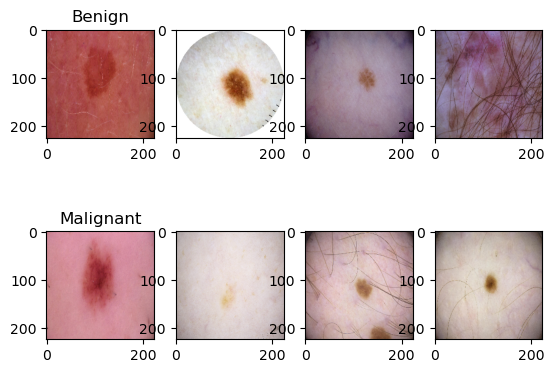

In [ ]:
import matplotlib.pyplot as plt

# Get the first few images from each class
class_0_images = train_generator.next()[0]
class_1_images = test_generator.next()[0]

# Create a figure and subplots
fig, axs = plt.subplots(2, 4)

# Plot the images
axs[0,0].set_title("Benign")
for j in range(4):
    axs[0, j].imshow(class_0_images[j])
axs[1,0].set_title("Malignant")
for j in range(4):
    axs[1, j].imshow(class_1_images[j])


# Show the figure
plt.show()

## Util

In [10]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

EVAL_METRICS_HEADER = ["Model", "Accuracy Train", "Precision Train", "Recall Train", "F1 Train", "Accuracy Test", "Precision Test", "Recall Test", "F1 Test"]

def init_metrics_df():
    return pd.DataFrame(columns=EVAL_METRICS_HEADER)

def plot_loss_curve(model_hist):
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'])
    plt.plot(model_hist.history['loss'])
    plt.plot(model_hist.history['val_loss'])

def plot_train_val_accuracy(model_hist):
    plt.plot(model_hist.history['accuracy'])
    plt.plot(model_hist.history['val_accuracy'])
    plt.title("Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'])
    plt.show()

from sklearn import metrics
#definition of error metrics function
def get_metrics(train_act,train_pred,test_act,test_pred,model_description,dataframe):
    precision_train = metrics.precision_score(train_act,train_pred)
    recall_train = metrics.recall_score(train_act,train_pred)
    f1_train = metrics.f1_score(train_act,train_pred)
    accuracy_train = metrics.accuracy_score(train_act,train_pred)
    precision_test = metrics.precision_score(test_act,test_pred)
    recall_test = metrics.recall_score(test_act,test_pred)
    f1_test = metrics.f1_score(test_act,test_pred)
    accuracy_test = metrics.accuracy_score(test_act,test_pred)
    s1=pd.Series([model_description,accuracy_train, precision_train,recall_train,f1_train,accuracy_test, precision_test,recall_test,f1_test],
                                           index=EVAL_METRICS_HEADER)
    dataframe = dataframe.append(s1, ignore_index=True)
    return(dataframe)

def plot_confusion_matrix(true, predicted, labels=["Benign", "Malignant"]):
    confusion_matrix = metrics.confusion_matrix(true, predicted)
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap='Blues')

    # Set labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")

    # Set colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set title and labels
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    # Show the plot
    plt.show()

def get_labels(datagenObj):
    all_labels = []

    # Iterate over the generator to collect images and labels
    for _ in range(len(datagenObj)):
        images, labels = next(datagenObj)
        all_labels.append(labels)

    # Concatenate the images and labels into single arrays
    all_labels = np.concatenate(all_labels, axis=0)

    return all_labels

Y_TRAIN = get_labels(train_generator)
Y_TEST = get_labels(test_generator)
print("Number of train labels = ", len(Y_TRAIN))
print("Number of test labels = ", len(Y_TEST))

def _metrics(train_dgn, test_dtgn, model, model_hist, model_description, dataframe):
    train_pred = model.predict(train_dgn)
    train_pred = (train_pred > 0.5).astype(int)
    test_pred = model.predict(test_dtgn)
    test_pred = (test_pred > 0.5).astype(int)
    df = get_metrics(Y_TRAIN, train_pred, Y_TEST, test_pred, model_description, dataframe)

    print("Train Classification Report")
    print(metrics.classification_report(Y_TRAIN, train_pred))

    print("Train Confusion Matrix")
    plot_confusion_matrix(Y_TRAIN, train_pred)

    print("Test Classification Report")
    print(metrics.classification_report(Y_TEST, test_pred))

    print("Test Confusion Matrix")
    plot_confusion_matrix(Y_TEST, test_pred)

    print("Train vs Validation Accuracy")
    plot_train_val_accuracy(model_hist)

    print("Train vs Validation Loss")
    plot_loss_curve(model_hist)
    return df

def tl_model(tl):
    model = Sequential()
    model.add(tl)
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))
    return model



Number of train labels =  240
Number of test labels =  50


In [11]:
scores = init_metrics_df()

## VGG16

In [8]:
from tensorflow.keras.applications import VGG16

# Load the VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# for layer in vgg16.layers:
#     layer.trainable = False

vgg_model = tl_model(vgg16)

vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 15  # Example number of training epochs

print(vgg_model.summary())
vgg_hist = vgg_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 14,739,777
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
8/8 [==============================] - 81s 7s/step - loss: 1.8324 - accuracy: 0.5708 - val_loss: 0.6922 - val_accuracy: 0.4667
Epoch 2/15
8/8 [==============================] - 40s 5s/step - loss: 0.7463 - accuracy: 0.5083 - va

2/2 [==============================] - 9s 3s/step
Train Classification Report
              precision    recall  f1-score   support

         0.0       0.76      0.58      0.66       120
         1.0       0.66      0.82      0.73       120

    accuracy                           0.70       240
   macro avg       0.71      0.70      0.70       240
weighted avg       0.71      0.70      0.70       240

Train Confusion Matrix


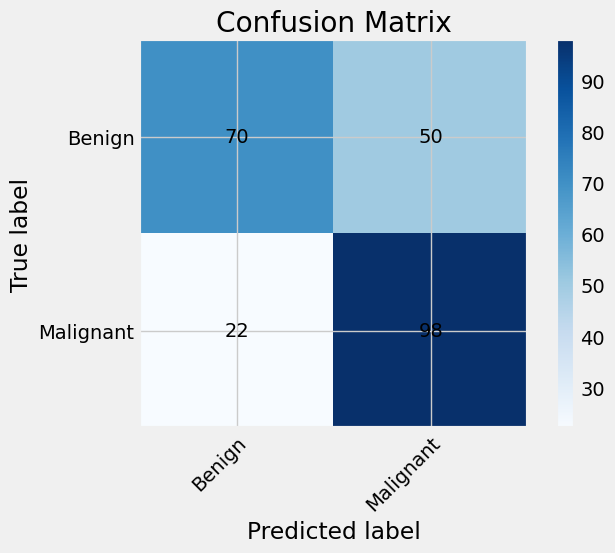

Test Classification Report
              precision    recall  f1-score   support

         0.0       0.78      0.72      0.75        25
         1.0       0.74      0.80      0.77        25

    accuracy                           0.76        50
   macro avg       0.76      0.76      0.76        50
weighted avg       0.76      0.76      0.76        50

Test Confusion Matrix


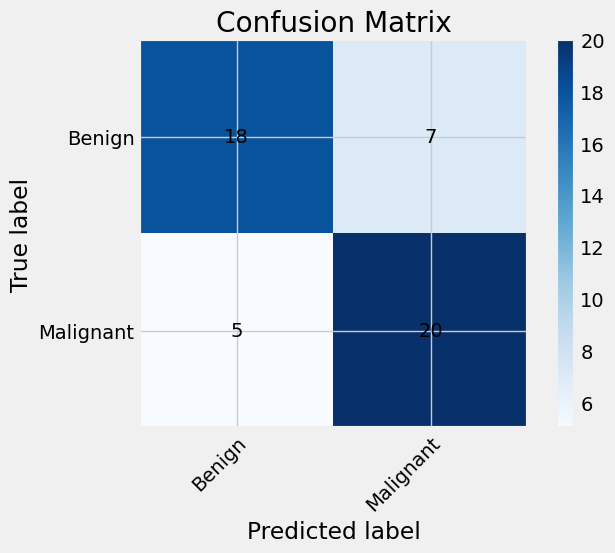

Train vs Validation Accuracy


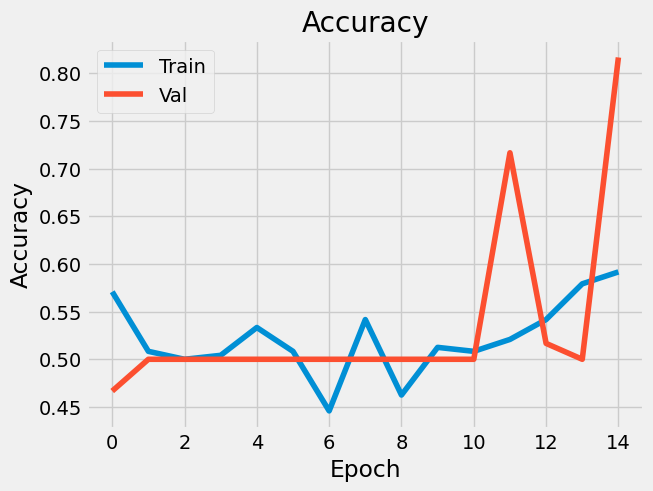

Train vs Validation Loss


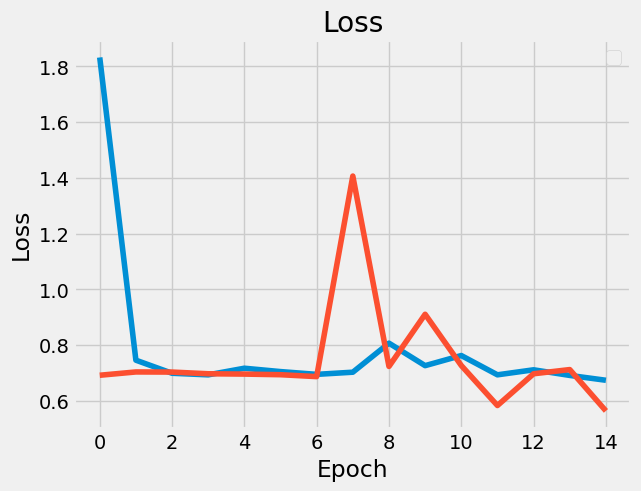

In [12]:
scores = _metrics(train_generator, test_generator, vgg_model, vgg_hist, "VGG16", scores)

In [13]:
scores

,Model,Accuracy Train,Precision Train,Recall Train,F1 Train,Accuracy Test,Precision Test,Recall Test,F1 Test
0,VGG16,0.7,0.662162,0.816667,0.731343,0.76,0.740741,0.8,0.769231


In [14]:
vgg_model.save("vgg16.h5")

## ResNet

In [15]:
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model (excluding the top layer)
res_net50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

res_net_model = tl_model(res_net50)

res_net_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 15  # Example number of training epochs

print(res_net_model.summary())
res_net_hist = res_net_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 100353    
                                                                 
Total params: 23,688,065
Trainable params: 23,634,945
Non-trainable params: 53,120
_________________________________________________________________
None
Epoch 1/15
8/8 [==============================] - 89s 6s/step - loss: 4.4687 - accuracy: 0.6042 - val_loss: 23.3824 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 42s 5s/step - loss: 3.4897 - accuracy: 0.7

2/2 [==============================] - 10s 4s/step
Train Classification Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       120
         1.0       0.50      1.00      0.67       120

    accuracy                           0.50       240
   macro avg       0.25      0.50      0.33       240
weighted avg       0.25      0.50      0.33       240

Train Confusion Matrix


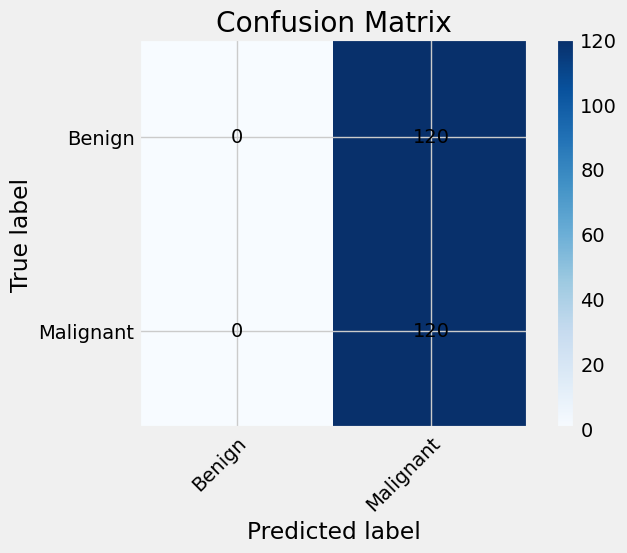

Test Classification Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        25
         1.0       0.50      1.00      0.67        25

    accuracy                           0.50        50
   macro avg       0.25      0.50      0.33        50
weighted avg       0.25      0.50      0.33        50

Test Confusion Matrix


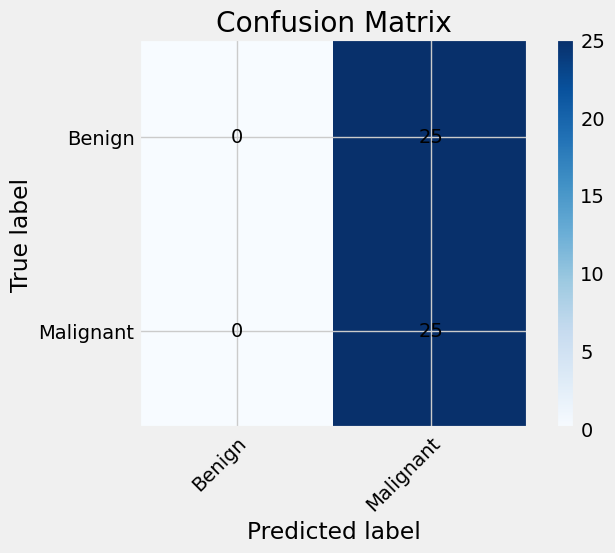

Train vs Validation Accuracy


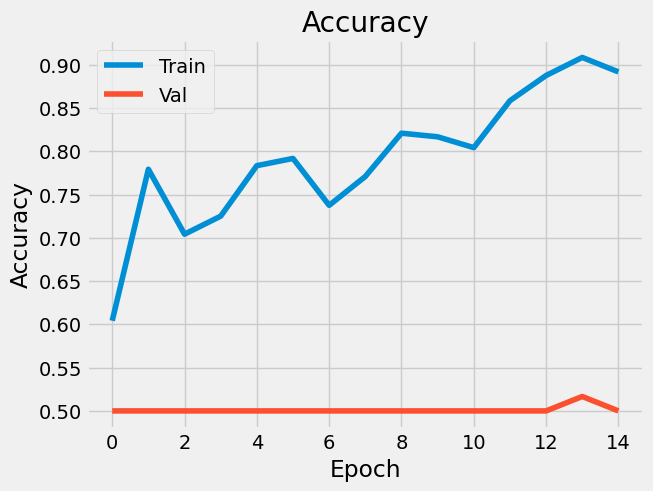

Train vs Validation Loss


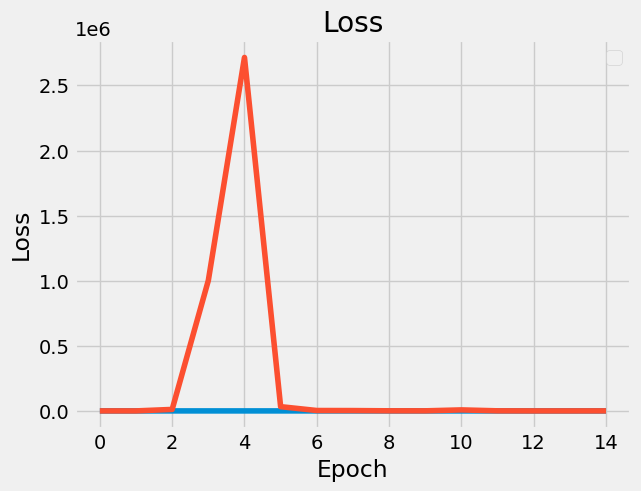

In [16]:
scores = _metrics(train_generator, test_generator, res_net_model, res_net_hist, "ResNet50", scores)

In [17]:
scores

,Model,Accuracy Train,Precision Train,Recall Train,F1 Train,Accuracy Test,Precision Test,Recall Test,F1 Test
0,VGG16,0.7,0.662162,0.816667,0.731343,0.76,0.740741,0.8,0.769231
1,ResNet50,0.5,0.500000,1.000000,0.666667,0.50,0.500000,1.0,0.666667


In [18]:
res_net_model.save("resnet50.h5")

## Inception

In [19]:
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model (excluding the top layer)
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

inception_model = tl_model(inception)

inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 15  # Example number of training epochs

print(inception_model.summary())
inception_hist = inception_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51201     
                                                                 
Total params: 21,853,985
Trainable params: 21,819,553
Non-trainable params: 34,432
_________________________________________________________________
None
Epoch 1/15
8/8 [==============================] - 105s 6s/step - loss: 1.9097 - accuracy: 0.5583 - val_loss: 1.6399 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 48s 6s/step - loss: 0.4869 - accuracy: 0.7

2/2 [==============================] - 9s 4s/step
Train Classification Report
              precision    recall  f1-score   support

         0.0       0.50      0.47      0.48       120
         1.0       0.50      0.54      0.52       120

    accuracy                           0.50       240
   macro avg       0.50      0.50      0.50       240
weighted avg       0.50      0.50      0.50       240

Train Confusion Matrix


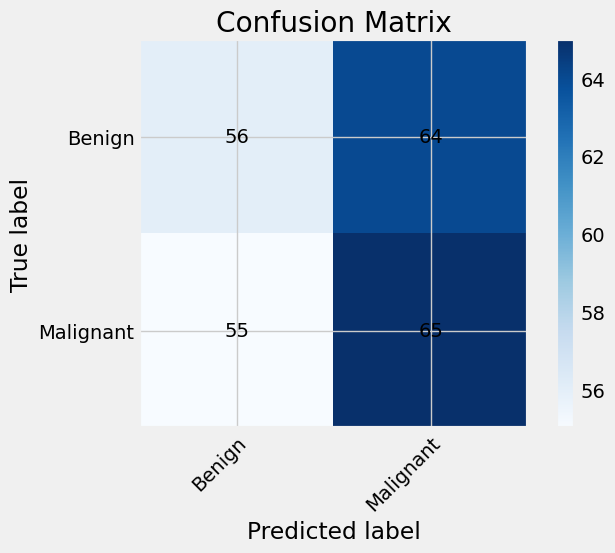

Test Classification Report
              precision    recall  f1-score   support

         0.0       0.41      0.36      0.38        25
         1.0       0.43      0.48      0.45        25

    accuracy                           0.42        50
   macro avg       0.42      0.42      0.42        50
weighted avg       0.42      0.42      0.42        50

Test Confusion Matrix


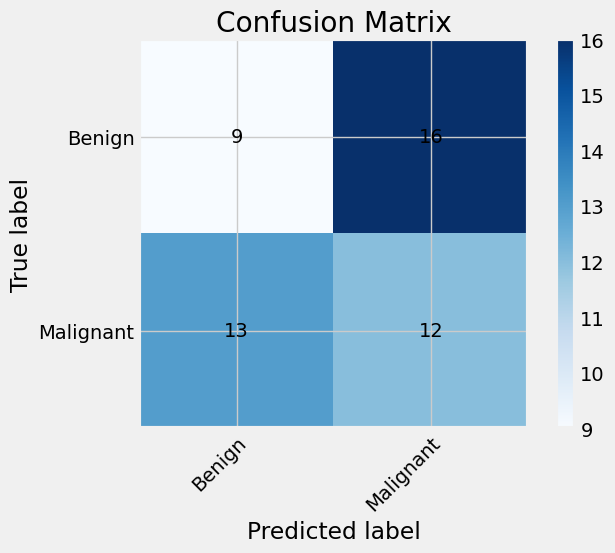

Train vs Validation Accuracy


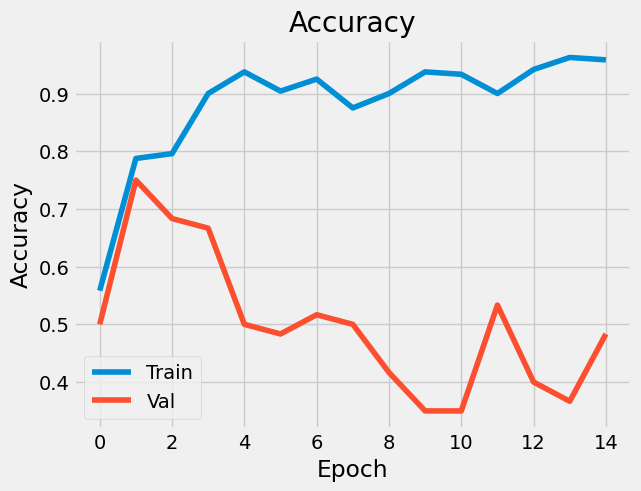

Train vs Validation Loss


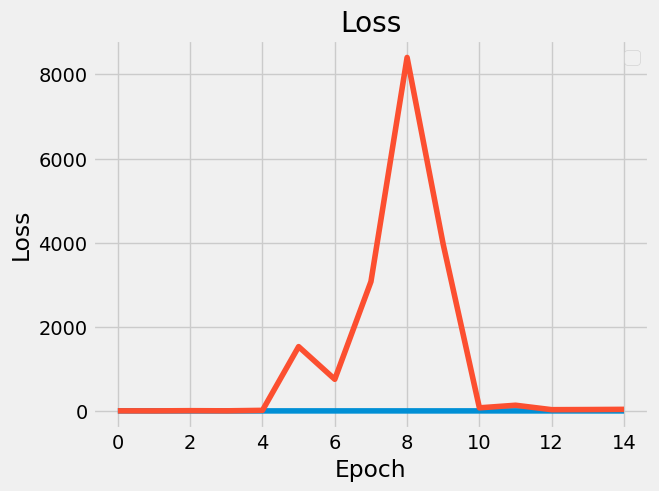

In [20]:
scores = _metrics(train_generator, test_generator, inception_model, inception_hist, "InceptionV3", scores)

In [21]:
scores

,Model,Accuracy Train,Precision Train,Recall Train,F1 Train,Accuracy Test,Precision Test,Recall Test,F1 Test
0,VGG16,0.700000,0.662162,0.816667,0.731343,0.76,0.740741,0.80,0.769231
1,ResNet50,0.500000,0.500000,1.000000,0.666667,0.50,0.500000,1.00,0.666667
2,InceptionV3,0.504167,0.503876,0.541667,0.522088,0.42,0.428571,0.48,0.452830


In [22]:
inception_model.save("inceptionv3.h5")

## MobileNet

In [23]:
from tensorflow.keras.applications import MobileNet

mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

mobilenet_model = tl_model(mobilenet)

mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 15  # Example number of training epochs

print(mobilenet_model.summary())
mobilenet = mobilenet_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 50176)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 50177     
                                                                 
Total params: 3,279,041
Trainable params: 3,257,153
Non-trainable params: 21,888
_________________________________________________________________
None
Epoch 1/15
8/8 [==============================] - 72s 6s/step - loss: 5.7945 - accuracy: 0.5750 - val_loss: 1.7550 - val_accuracy: 0.7000
Epoch 2/15
8/8 [=============

2/2 [==============================] - 8s 4s/step
Train Classification Report
              precision    recall  f1-score   support

         0.0       0.55      0.53      0.54       120
         1.0       0.55      0.57      0.56       120

    accuracy                           0.55       240
   macro avg       0.55      0.55      0.55       240
weighted avg       0.55      0.55      0.55       240

Train Confusion Matrix


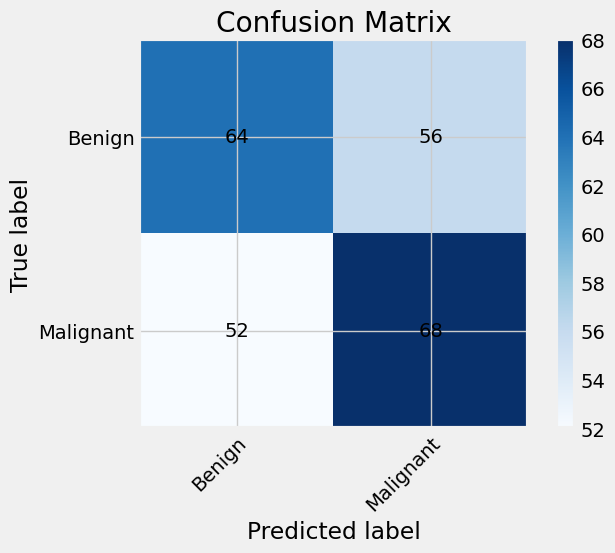

Test Classification Report
              precision    recall  f1-score   support

         0.0       0.48      0.48      0.48        25
         1.0       0.48      0.48      0.48        25

    accuracy                           0.48        50
   macro avg       0.48      0.48      0.48        50
weighted avg       0.48      0.48      0.48        50

Test Confusion Matrix


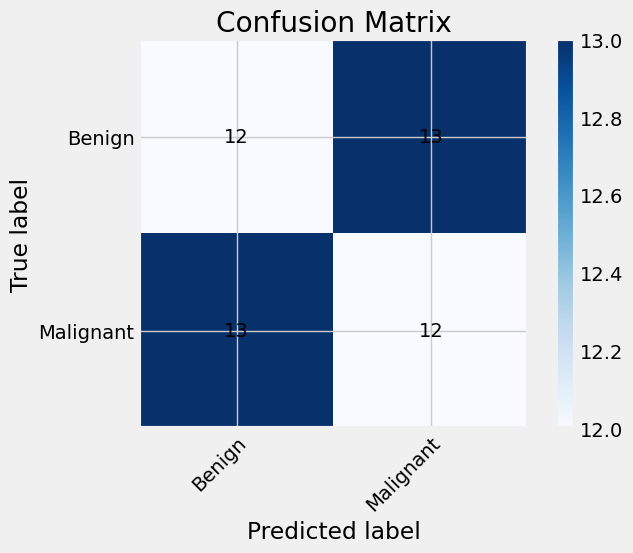

Train vs Validation Accuracy


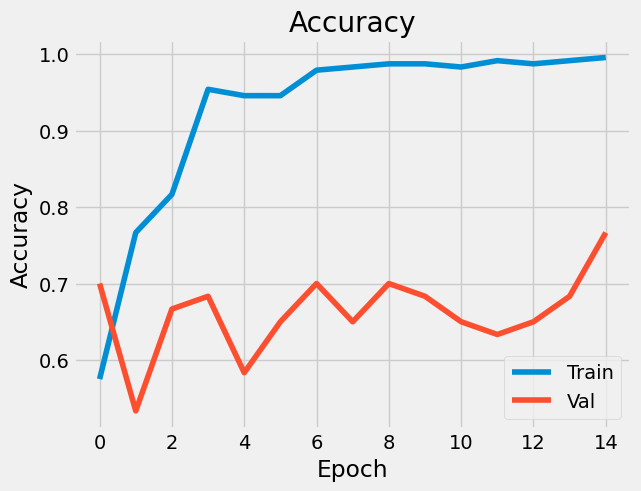

Train vs Validation Loss


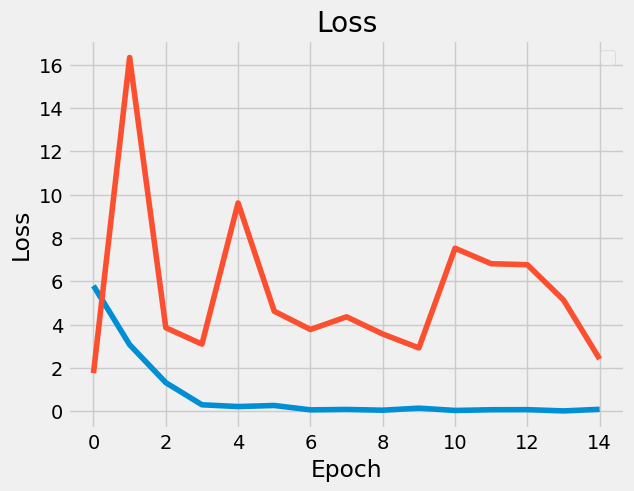

In [24]:
scores = _metrics(train_generator, test_generator, mobilenet_model, mobilenet, "MobileNet", scores)

In [25]:
scores

,Model,Accuracy Train,Precision Train,Recall Train,F1 Train,Accuracy Test,Precision Test,Recall Test,F1 Test
0,VGG16,0.700000,0.662162,0.816667,0.731343,0.76,0.740741,0.80,0.769231
1,ResNet50,0.500000,0.500000,1.000000,0.666667,0.50,0.500000,1.00,0.666667
2,InceptionV3,0.504167,0.503876,0.541667,0.522088,0.42,0.428571,0.48,0.452830
3,MobileNet,0.550000,0.548387,0.566667,0.557377,0.48,0.480000,0.48,0.480000


In [26]:
mobilenet_model.save("mobilenet.h5")

## Xception

In [27]:
from tensorflow.keras.applications import Xception

xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

xception_model = tl_model(xception)

xception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 15  # Example number of training epochs

print(xception_model.summary())
xception_hist = xception_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 1)                 100353    
                                                                 
Total params: 20,961,833
Trainable params: 20,907,305
Non-trainable params: 54,528
_________________________________________________________________
None
Epoch 1/15
8/8 [==============================] - 91s 6s/step - loss: 1.0555 - accuracy: 0.4958 - val_loss: 1.8276 - val_accuracy: 0.4833
Epoch 2/15
8/8 [==============================] - 41s 5s/step - loss: 0.6931 - accuracy: 0.51

2/2 [==============================] - 10s 4s/step
Train Classification Report
              precision    recall  f1-score   support

         0.0       0.49      0.92      0.64       120
         1.0       0.33      0.04      0.07       120

    accuracy                           0.48       240
   macro avg       0.41      0.48      0.36       240
weighted avg       0.41      0.48      0.36       240

Train Confusion Matrix


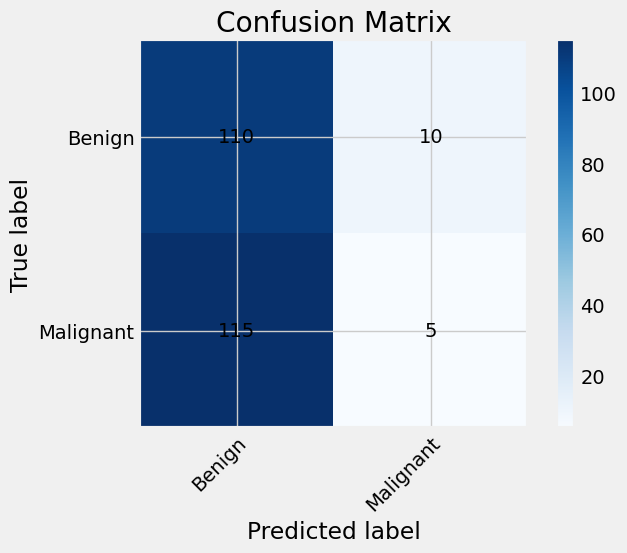

Test Classification Report
              precision    recall  f1-score   support

         0.0       0.51      1.00      0.68        25
         1.0       1.00      0.04      0.08        25

    accuracy                           0.52        50
   macro avg       0.76      0.52      0.38        50
weighted avg       0.76      0.52      0.38        50

Test Confusion Matrix


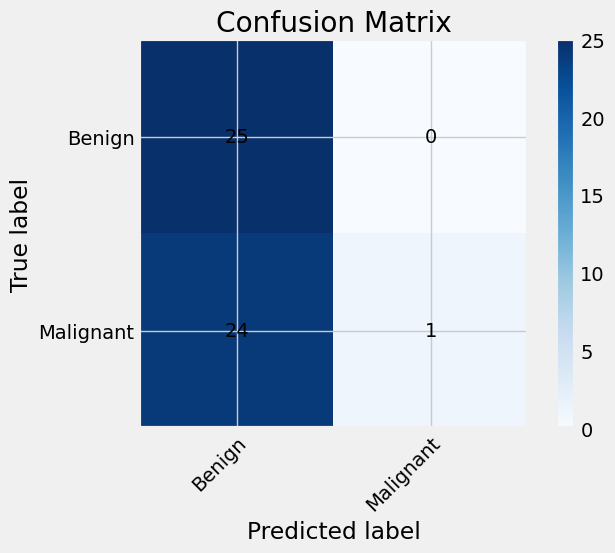

Train vs Validation Accuracy


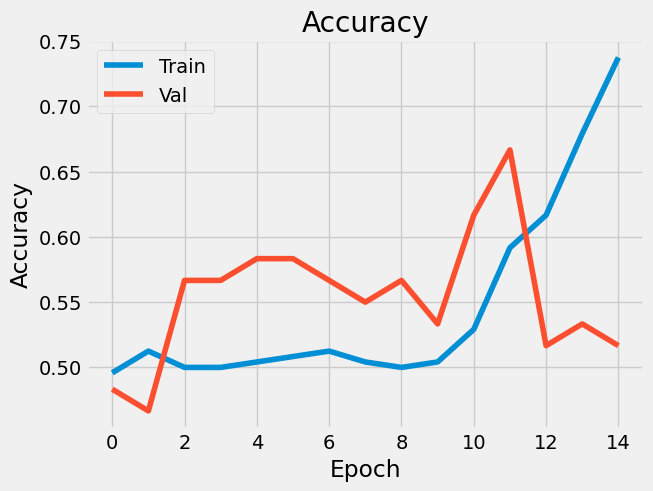

Train vs Validation Loss


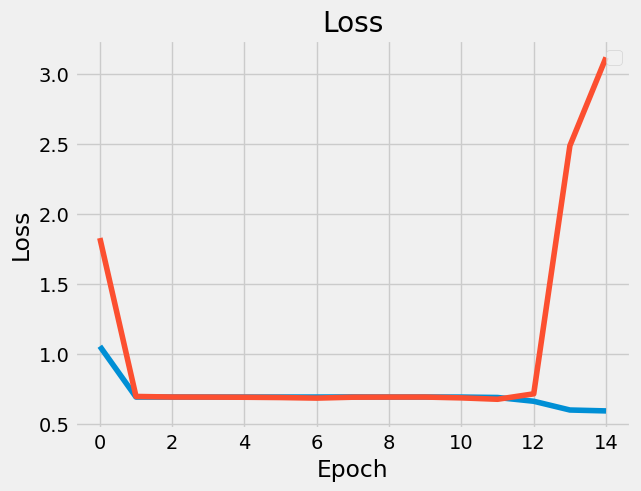

In [28]:
scores = _metrics(train_generator, test_generator, xception_model, xception_hist, "Xception", scores)

In [29]:
scores

,Model,Accuracy Train,Precision Train,Recall Train,F1 Train,Accuracy Test,Precision Test,Recall Test,F1 Test
0,VGG16,0.700000,0.662162,0.816667,0.731343,0.76,0.740741,0.80,0.769231
1,ResNet50,0.500000,0.500000,1.000000,0.666667,0.50,0.500000,1.00,0.666667
2,InceptionV3,0.504167,0.503876,0.541667,0.522088,0.42,0.428571,0.48,0.452830
3,MobileNet,0.550000,0.548387,0.566667,0.557377,0.48,0.480000,0.48,0.480000
4,Xception,0.479167,0.333333,0.041667,0.074074,0.52,1.000000,0.04,0.076923


In [30]:
xception_model.save("xception.h5")

In [31]:
scores.to_csv("TL_results.csv", index=False)